In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.model_selection import learning_curve


In [2]:
# Fixing the directory path 
import os
os.chdir("C:/Users/RAZER BLADE/Downloads/AI Path/Multi-Class-Classification")

In [3]:
data = pd.read_csv("Datasets/train.csv")

Basic Preprocessing

In [4]:
df = data.copy()

# Drop the age column 
df = df.drop(['Age'], axis=1)

# Replace the numerical value of Hepatomegaly 
df.loc[df['Hepatomegaly'] == '119.35', 'Hepatomegaly'] = df['Hepatomegaly'].mode()[0]

Nan Values

In [11]:
# replacing the median and mode 
def imputation_statistics(df_fill):
    """ impute null values with mode for categorical variables and median for numerical ones
    """
    for col in df_fill.columns:
        if df_fill[col].isna().any():
            if col in list(df_fill.select_dtypes(['float', 'int']).columns):
                df_fill[col] = df_fill[col].fillna(df_fill[col].median())
            elif col in list(df_fill.select_dtypes('object').columns):
                df_fill[col] = df_fill[col].fillna(df_fill[col].mode()[0])
    return df_fill

df_fill = imputation_statistics(df)
df_fill.isna().any()

id               False
N_Days           False
Drug             False
Sex              False
Ascites          False
Hepatomegaly     False
Spiders          False
Edema            False
Bilirubin        False
Cholesterol      False
Albumin          False
Copper           False
Alk_Phos         False
SGOT             False
Tryglicerides    False
Platelets        False
Prothrombin      False
Stage            False
Status           False
dtype: bool

Feature Engineering

In [20]:
Y = df_fill['Status']
X = df_fill.drop(['Status', 'id'], axis=1)
print(X.shape, Y.shape)

(15000, 17) (15000,)


Encoding 

In [18]:
def encoding(X):
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    X_encoded = pd.get_dummies(X, columns=categorical_cols)
    def encodage(df):
        code = {True:1,
            False:0}
    
        for col in df.select_dtypes(['object', 'bool']).columns:
            df.loc[:,col] = df[col].map(code)
        return df

    X_encoded = encodage(X_encoded)
    return X_encoded
X_encoded = encoding(X)
X_encoded.dtypes


N_Days                     float64
Bilirubin                  float64
Cholesterol                float64
Albumin                    float64
Copper                     float64
Alk_Phos                   float64
SGOT                       float64
Tryglicerides              float64
Platelets                  float64
Prothrombin                float64
Stage                      float64
Drug_D-penicillamine         int64
Drug_Placebo                 int64
Sex_F                        int64
Sex_M                        int64
Ascites_D-penicillamine      int64
Ascites_N                    int64
Ascites_S                    int64
Ascites_Y                    int64
Hepatomegaly_N               int64
Hepatomegaly_Y               int64
Spiders_N                    int64
Spiders_Y                    int64
Edema_N                      int64
Edema_S                      int64
Edema_Y                      int64
dtype: object

In [23]:
def target_encoding(Y):

    code = {'C':1, 'D':0, 'CL':2}
    Y = Y.map(code)
    return Y
Y_encoded = target_encoding(Y)
Y_encoded.value_counts()


Status
1    10049
0     4560
2      391
Name: count, dtype: int64

In [25]:
from sklearn.model_selection import train_test_split

X_train,  X_test, Y_train, Y_test = train_test_split(X_encoded, Y_encoded, test_size=.2, random_state=8)
print('Trainning Shape', X_train.shape, Y_train.shape)
print('Trainning Shape', X_test.shape, Y_test.shape)

Trainning Shape (12000, 26) (12000,)
Trainning Shape (3000, 26) (3000,)


Scaling 

In [27]:
from sklearn.preprocessing import RobustScaler
def scaling(X_train, X_test):
    X_train_tf = X_train.copy()
    X_test_tf = X_test.copy()
    numerical_features = list(X_train.select_dtypes('float').columns)
    #only scale numeric varaibles in this case rather than the dummy variables for categories 
    rob = RobustScaler()
    X_train_tf.loc[:, numerical_features] = rob.fit_transform(X_train_tf.loc[:, numerical_features])
    X_test_tf.loc[:, numerical_features] = rob.transform(X_test_tf.loc[:, numerical_features])
    return X_train_tf, X_test_tf

X_train_tf, X_test_tf = scaling(X_train, X_test) 

,N_Days,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,...,Ascites_N,Ascites_S,Ascites_Y,Hepatomegaly_N,Hepatomegaly_Y,Spiders_N,Spiders_Y,Edema_N,Edema_S,Edema_Y
6544,0.125644,-0.166667,0.0,-0.604167,0.000000,0.000000,0.000000,0.0,0.239669,-0.777778,...,1,0,0,1,0,1,0,1,0,0
2135,-0.235825,0.083333,0.0,-1.187500,0.000000,0.000000,0.000000,0.0,-0.925620,-0.777778,...,1,0,0,1,0,1,0,1,0,0
857,-0.610825,2.166667,-21.0,-0.791667,32.666667,39.025157,2.230980,-21.0,-0.363636,0.555556,...,1,0,0,0,1,0,1,1,0,0
5609,0.567655,-0.083333,-28.0,0.062500,0.500000,1.037736,5.205620,-36.0,0.743802,0.000000,...,1,0,0,0,1,0,1,1,0,0
1742,-0.704897,0.750000,0.0,0.041667,0.000000,0.000000,0.000000,0.0,-0.900826,-0.222222,...,1,0,0,1,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2181,1.313144,-0.166667,-63.0,0.145833,-1.416667,4.496855,0.637423,47.0,0.438017,-1.111111,...,1,0,0,1,0,1,0,1,0,0
10601,1.452320,0.000000,-32.0,0.937500,-2.666667,-2.704403,-2.802605,-4.0,-0.190083,1.111111,...,1,0,0,1,0,1,0,1,0,0
2033,-0.269330,-0.083333,0.0,-0.375000,0.000000,0.000000,0.000000,0.0,-0.644628,-0.222222,...,1,0,0,1,0,1,0,1,0,0
9556,0.329897,-0.166667,2.0,-0.791667,0.000000,50.281761,-1.741604,12.0,2.578512,0.111111,...,1,0,0,0,1,1,0,1,0,0


Evaluation metrics 

In [29]:
# log loss function 
def log_loss(Y_test, y_pred_proba):
    """
    Calcule l'opposé de la log-vraisemblance pour un problème de classification multiclasse.
    
    :param Y_test: ndarray de shape (N, M), les vérités terrain encodées en one-hot (1 pour la classe vraie, 0 sinon).
    :param y_pred: ndarray de shape (N, M), les probabilités prédites pour chaque classe.
                   Chaque ligne doit contenir les probabilités non normalisées.
    :return: float, la log-vraisemblance négative normalisée.
    """
    # Normaliser les probabilités
    y_pred_proba = y_pred_proba / np.sum(y_pred_proba, axis=1, keepdims=True)
    
    # Éviter les extrêmes du logarithme
    epsilon = 1e-15
    y_pred_proba = np.clip(y_pred_proba, epsilon, 1 - epsilon)

    N = Y_test.shape[0]
    M = y_pred_proba.shape[1]
    y_one_hot = np.zeros((N, M))
    y_one_hot[np.arange(N), Y_test] = 1
    
    # Calcul de la log-vraisemblance
    log_loss = -np.sum(y_one_hot * np.log(y_pred_proba)) / Y_test.shape[0]
    
    return log_loss

In [30]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)

def evaluate_model(Y_test, Y_pred, y_pred_proba):

    loglosss = log_loss(Y_test, y_pred_proba)
    accuracy = accuracy_score(Y_test, Y_pred)
    precision = precision_score(Y_test, Y_pred, average='micro')
    recall = recall_score(Y_test, Y_pred, average='micro')
    f1 = f1_score(Y_test, Y_pred, average='micro')
    
    return accuracy, precision, recall, f1, loglosss

Model Trainer

In [32]:
# Initialize the models
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=5),  # Default k=5
    'Decision Tree': DecisionTreeClassifier(max_depth=None, random_state=42),
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
}

In [33]:
def trainning_models(models, X_train, Y_train, X_test, Y_test):
    for i in range(len(list(models))):
        model = list(models.values())[i]
        model.fit(X_train, Y_train) # Train model

        # Make predictions
        Y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)

        # Evaluate Test dataset
        accuracy, precision, recall, f1, logloss = evaluate_model(Y_test, Y_pred, y_pred_proba)
        print(model)
        print("Accuracy: {0}".format(accuracy))
        print("Precision: {0}".format(precision))
        print("Recall: {0}".format(recall))
        print("f1: {0}".format(f1))
        print("logloss: {0}".format(logloss))
        
        # Confusion Matrix
        cm = confusion_matrix(Y_test, Y_pred)
        plt.figure()
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(Y_test.unique()), yticklabels=list(Y_test.unique()))
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.title('Confusion Matrix')
        plt.xticks(rotation=0)
        plt.tight_layout()
        plt.gca().xaxis.set_label_position('top')  # Move x-axis label to the top
        plt.gca().xaxis.tick_top()                # Move x-axis ticks to the top
        plt.show()

        print('='*35)
        print('\n')

KNeighborsClassifier()
Accuracy: 0.7913333333333333
Precision: 0.7913333333333333
Recall: 0.7913333333333333
f1: 0.7913333333333333
logloss: 2.502921930548284


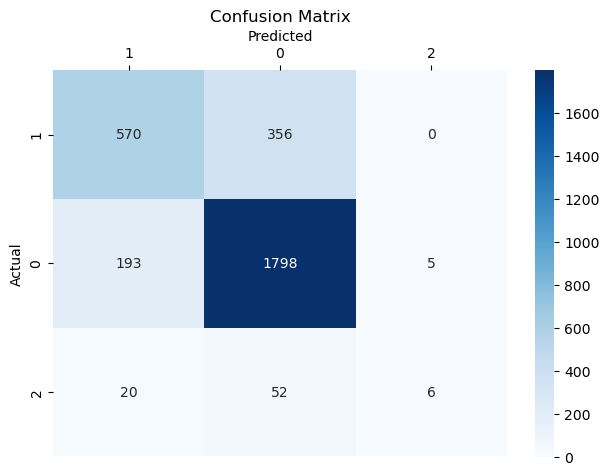



DecisionTreeClassifier(random_state=42)
Accuracy: 0.777
Precision: 0.777
Recall: 0.777
f1: 0.777
logloss: 7.702378185125269


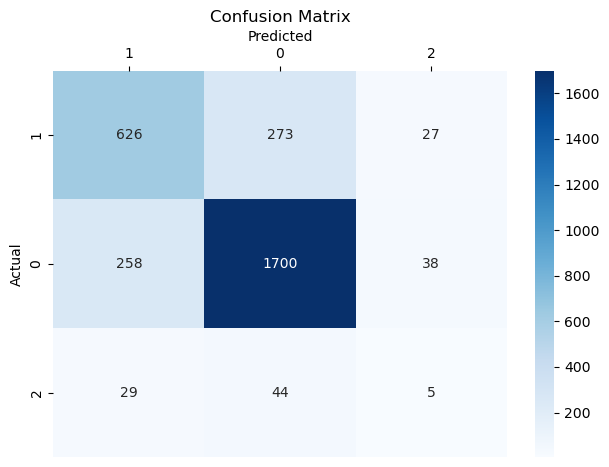



GaussianNB()
Accuracy: 0.542
Precision: 0.542
Recall: 0.542
f1: 0.542
logloss: 4.712125964690147


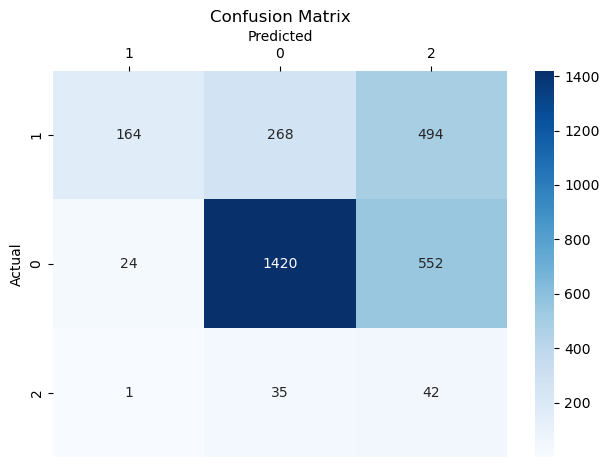



RandomForestClassifier(random_state=42)
Accuracy: 0.8453333333333334
Precision: 0.8453333333333334
Recall: 0.8453333333333334
f1: 0.8453333333333334
logloss: 0.49702591890189385


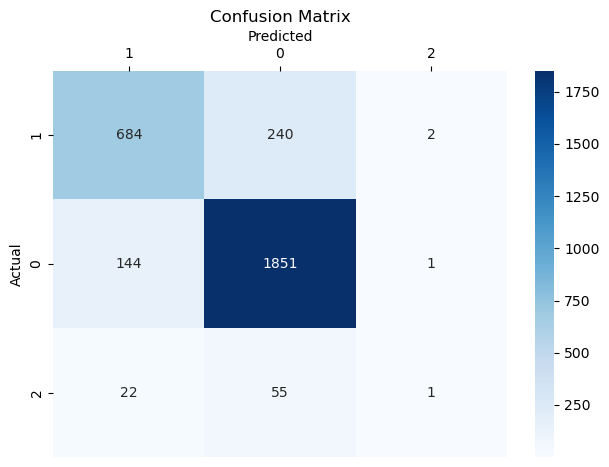



GradientBoostingClassifier(random_state=42)
Accuracy: 0.8526666666666667
Precision: 0.8526666666666667
Recall: 0.8526666666666667
f1: 0.8526666666666667
logloss: 0.39118980259043035


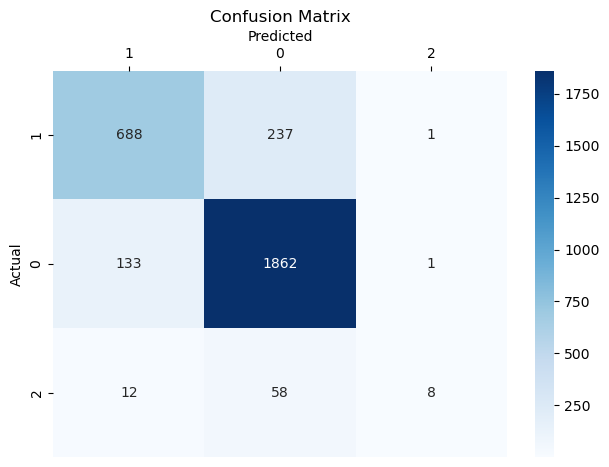

In [34]:
trainning_models(models, X_train_tf, Y_train.to_numpy(), X_test_tf, Y_test)

Tree Based models are the best since our Dataset has a lot of outliers

##### Enhancing model's performance with Data processing techniques 

In [52]:
from imblearn.over_sampling import SMOTE 

smote = SMOTE(sampling_strategy = {1:8053, 2:3634, 0:3634} , random_state = 42) 

X_smote, y_smote = smote.fit_resample(X_train_tf,Y_train)
y_smote.value_counts()


Status
1    8053
2    3634
0    3634
Name: count, dtype: int64

In [51]:
Y_train.value_counts()

Status
1    8053
0    3634
2     313
Name: count, dtype: int64

KNeighborsClassifier()
Accuracy: 0.733
Precision: 0.733
Recall: 0.733
f1: 0.733
logloss: 3.398257930086048


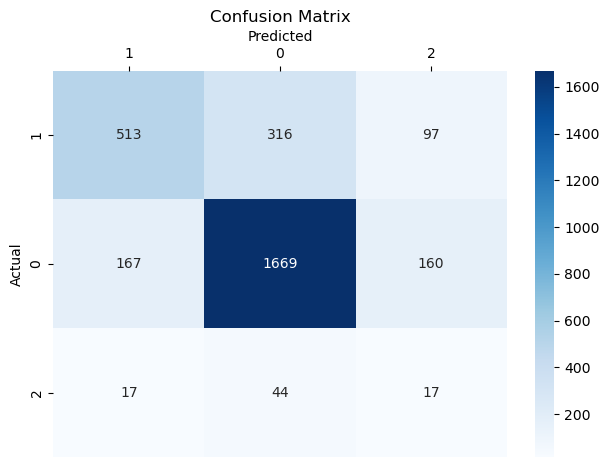



DecisionTreeClassifier(random_state=42)
Accuracy: 0.7473333333333333
Precision: 0.7473333333333333
Recall: 0.7473333333333333
f1: 0.7473333333333333
logloss: 8.726797502447434


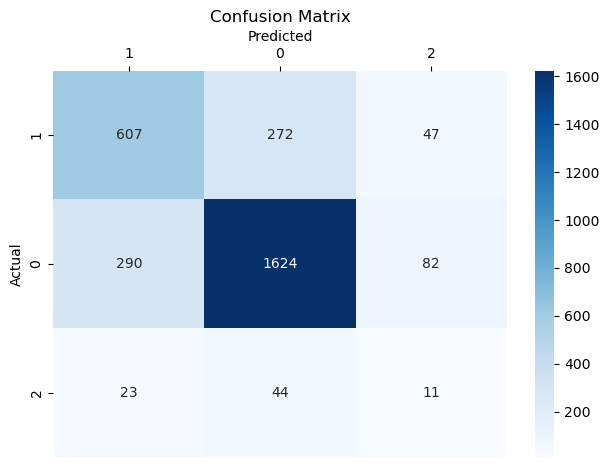



GaussianNB()
Accuracy: 0.24966666666666668
Precision: 0.24966666666666668
Recall: 0.24966666666666668
f1: 0.24966666666666668
logloss: 5.148098634770211


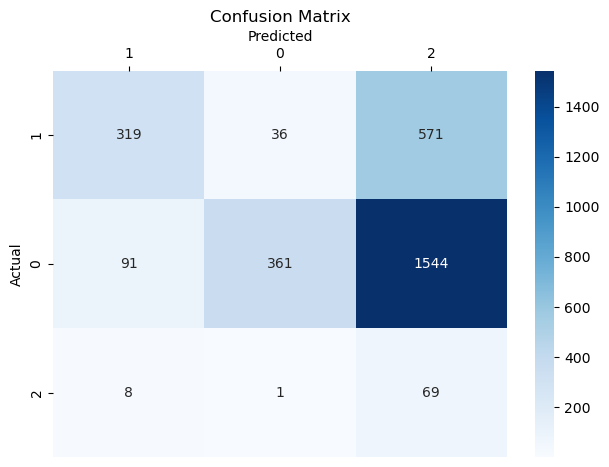



RandomForestClassifier(random_state=42)
Accuracy: 0.837
Precision: 0.837
Recall: 0.837
f1: 0.837
logloss: 0.4811012334761767


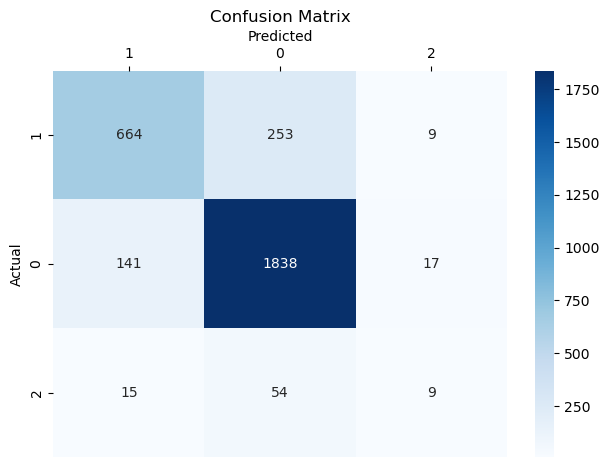



GradientBoostingClassifier(random_state=42)
Accuracy: 0.8456666666666667
Precision: 0.8456666666666667
Recall: 0.8456666666666667
f1: 0.8456666666666667
logloss: 0.42668992863111793


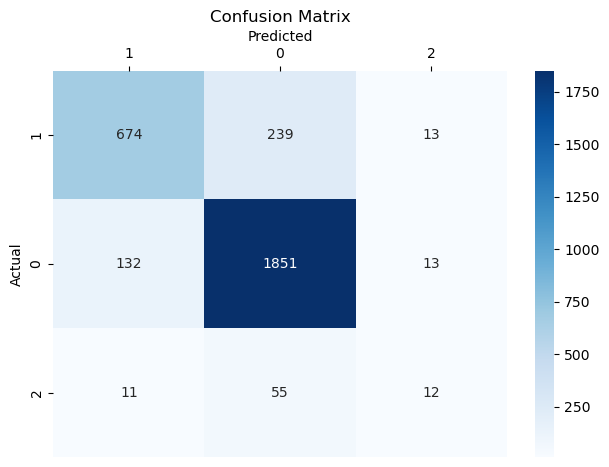

In [53]:
trainning_models(models, X_smote, y_smote.to_numpy(), X_test_tf, Y_test)